In [1]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import string
%pylab inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF
from nltk.corpus import stopwords
from collections import defaultdict
from collections import Counter
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from textblob import TextBlob
from gensim.models import Word2Vec

Populating the interactive namespace from numpy and matplotlib


In [2]:
all_df = pd.read_pickle("/Users/danielgilberg/data_science/metis/nlp_partisanship/data/all_committees.pkl")

In [53]:
def get_party_classification(party):
    if party == "Democratic":
        return 0
    else:
        return 1

In [52]:
def get_coords(matrix2D):
    x = []
    y = []
    for r in matrix2D:
        x.append(r[0])
        y.append(r[1])
    return x, y

#### Foreign Relations Committee

In [5]:
fr_df = all_df[all_df.Committee == "Foreign Relations"]
fr_releases = list(fr_df.Release)

In [9]:
my_stops = stopwords.words()
fr_corpus = list()
lengths = defaultdict(int)
for index, release in enumerate(fr_releases):
    sents = nltk.sent_tokenize(release)
    lengths[index] += len(sents)
    fr_corpus += sents

In [22]:
fr_tfidf = TfidfVectorizer(max_df=0.99, min_df=0.01, stop_words=my_stops, 
                        token_pattern="\\b[a-z][a-z]+\\b", ngram_range=(1,2))
fr_vector = fr_tfidf.fit_transform(corpus)

In [24]:
fr_nmf = NMF(n_components=15, init="random", random_state=42)
fr_scores = fr_nmf.fit_transform(fr_vector)

In [25]:
for topic_idx, topic in enumerate(fr_nmf.components_):
    print ("Topic #%d:" % topic_idx)
    print (" ".join([fr_tfidf.get_feature_names()[i]
                    for i in topic.argsort()[:-10 - 1:-1]]))

Topic #0:
committee foreign senate relations foreign relations relations committee senate foreign chairman member ranking
Topic #1:
washington washington dc dc john john kerry kerry today committee chairman hearing letter
Topic #2:
today us one time hearing thank forward look many look forward
Topic #3:
cardin senator md cardin md senator cardin senators said corker bob bob corker
Topic #4:
president obama president obama congress trump mr letter congressional house agreement
Topic #5:
iran nuclear agreement sanctions weapons program deal congress review missile
Topic #6:
government political officials russian efforts violence including civil forces urge
Topic #7:
rights human human rights law democracy international civil freedom political act
Topic #8:
people american million country future democracy democratic violence continue day
Topic #9:
united states united states nations united nations allies international relationship china senate
Topic #10:
security national national securit

In [37]:
def get_rel_score(release):
    #print(len(release))
    try:
        sents = nltk.sent_tokenize(release)
    except:
        sents = list()
        
    if len(sents) > 0:
        sents_tf = fr_tfidf.transform(sents)
        
        sents_nmf = fr_nmf.transform(sents_tf)
       
        score = sents_nmf.mean(axis=0)
    else:
        score = [0]
    return tuple(score)

In [35]:
fr_df.head()

,Committee,Date,Day,Label,Month,Party,Release,Title,Year
6060,Foreign Relations,2017-11-17,NaN,"Democratic, Foreign Relations",NaN,Democratic,"WASHINGTON – U.S. Senator Ben Cardin (D-Md.),...",Cardin Presses State Dept. for Central America...,NaN
6061,Foreign Relations,2017-11-17,NaN,"Democratic, Foreign Relations",NaN,Democratic,"WASHINGTON – U.S. Senator Ben Cardin (D-Md.),...",Cardin Recognizes Eighth Anniversary of Sergei...,NaN
6062,Foreign Relations,2017-11-15,NaN,"Democratic, Foreign Relations",NaN,Democratic,"WASHINGTON – U.S. Senator Ben Cardin (D-Md.),...","Cardin Calls for Calm, Democratic Process in Z...",NaN
6063,Foreign Relations,2017-11-14,NaN,"Democratic, Foreign Relations",NaN,Democratic,"WASHINGTON – U.S. Senator Ben Cardin (D-Md.),...",Cardin: Widespread Human Suffering in Yemen Re...,NaN
6064,Foreign Relations,2017-11-14,NaN,"Democratic, Foreign Relations",NaN,Democratic,"WASHINGTON – U.S. Senator Ben Cardin (D-Md.),...",Cardin Remarks at Hearing on Use of Nuclear We...,NaN


In [38]:
get_rel_score(fr_df.loc[6060,"Release"])

(0.094400307359754132,
 0.059234050544209056,
 0.021314598921564062,
 0.092171861867001603,
 0.029254391458896866,
 0.00048539662477748683,
 0.034573681578144631,
 0.0076893030255307743,
 0.0037193604970707076,
 0.022024846905642846,
 0.048668621720126509,
 0.11612155645444107,
 0.05342039115848763,
 0.0015190786344523354,
 0.0081225299392019019)

In [47]:
temp_df = pd.concat([fr_df, fr_df.apply(lambda row: pd.Series(get_rel_score(row["Release"])), axis=1)], axis=1)
scores_df = temp_df.iloc[:, 9:]

In [48]:
scores_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
6060,0.094400,0.059234,0.021315,0.092172,0.029254,0.000485,0.034574,0.007689,0.003719,0.022025,0.048669,0.116122,0.053420,0.001519,0.008123
6061,0.112331,0.130044,0.002829,0.105077,0.008656,0.012106,0.080053,0.130309,0.000170,0.037715,0.002024,0.002660,0.038964,0.001556,0.042742
6062,0.181523,0.186068,0.001700,0.150110,0.003463,0.000000,0.138225,0.014723,0.067625,0.053685,0.001897,0.000136,0.027486,0.004584,0.006014
6063,0.080576,0.087107,0.016326,0.070051,0.001174,0.028745,0.023239,0.005756,0.114037,0.017228,0.024715,0.001167,0.033884,0.048268,0.003366
6064,0.052250,0.031277,0.082284,0.028871,0.116252,0.104225,0.001964,0.002455,0.035539,0.049457,0.016008,0.001365,0.041427,0.015758,0.007682
6065,0.092304,0.009077,0.051810,0.043782,0.025763,0.000867,0.014432,0.001621,0.003565,0.014564,0.049836,0.128749,0.042147,0.001006,0.027510
6066,0.069532,0.000294,0.004410,0.104483,0.065374,0.014778,0.014028,0.015519,0.065563,0.059576,0.052759,0.019647,0.043600,0.013100,0.045324
6067,0.198097,0.000000,0.000000,0.165155,0.117354,0.012483,0.001496,0.009684,0.000000,0.002061,0.001311,0.000553,0.030703,0.004101,0.005407
6068,0.083522,0.077334,0.018647,0.099876,0.005734,0.000023,0.018146,0.002152,0.023953,0.053970,0.037340,0.043706,0.031002,0.000568,0.001898
6069,0.264289,0.054772,0.024079,0.053283,0.003879,0.001336,0.028468,0.001601,0.003726,0.000340,0.117029,0.003394,0.033974,0.002216,0.020128


In [50]:
fr_tsne_model = TSNE(n_components=2, random_state=0, metric="cosine", method="exact")

In [51]:
fr_results = fr_tsne_model.fit_transform(scores_df)

In [56]:
fr_df["Party_Classification"] = fr_df.apply(lambda row: get_party_classification(row["Party"]), axis=1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [58]:
fr_x, fr_y = get_coords(fr_results)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


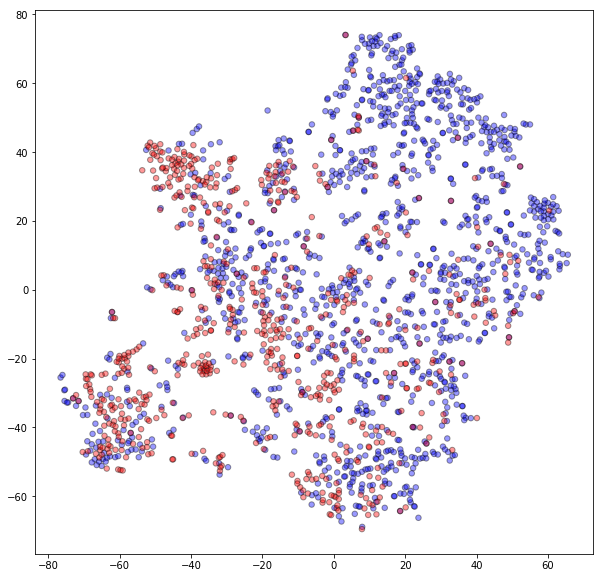

In [60]:
plt.figure(figsize=(10,10))
colors = np.array(["blue", "red"])
plt.scatter(fr_x, fr_y, alpha=0.4, c=colors[fr_df["Party_Classification"]], marker='o', s=30, cmap='tab10', edgecolor="black");
plt.legend()

#### 